In [1]:
import tensorflow as tf
import numpy as np

model = tf.keras.models.load_model(
    "spectrogram_autoencoder_section00.h5",
    custom_objects={"mse": tf.keras.losses.MeanSquaredError()}
)


In [2]:
dummy_input = tf.zeros((1, 224, 224, 1))
model(dummy_input)


<tf.Tensor: shape=(1, 224, 224, 1), dtype=float32, numpy=
array([[[[0.47797853],
         [0.46688256],
         [0.46385136],
         ...,
         [0.45297578],
         [0.45559555],
         [0.48023954]],

        [[0.46313405],
         [0.4462206 ],
         [0.43644485],
         ...,
         [0.42518535],
         [0.42135164],
         [0.45705777]],

        [[0.45677575],
         [0.42764193],
         [0.42170835],
         ...,
         [0.38947907],
         [0.40365136],
         [0.43943912]],

        ...,

        [[0.41948172],
         [0.37066555],
         [0.34687322],
         ...,
         [0.26653105],
         [0.28608912],
         [0.3754552 ]],

        [[0.42464274],
         [0.37044954],
         [0.35834846],
         ...,
         [0.2562321 ],
         [0.2899462 ],
         [0.37054777]],

        [[0.44091967],
         [0.39163125],
         [0.37746808],
         ...,
         [0.273545  ],
         [0.32085097],
         [0.374399  ]]]], sha

In [3]:
import tensorflow as tf

input_img = tf.keras.Input(shape=(224, 224, 1))


In [4]:
input_img = tf.keras.Input(shape=(224, 224, 1))

x = model.layers[0](input_img)  # conv
x = model.layers[1](x)          # pool

x = model.layers[2](x)
x = model.layers[3](x)

x = model.layers[4](x)
encoder_output = model.layers[5](x)   # <-- STOP HERE (28×28×128)

encoder = tf.keras.Model(input_img, encoder_output)
encoder.summary()


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 92,672 (362.00 KB)

 Trainable params: 92,672 (362.00 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
import os
import numpy as np

from PIL import Image
import numpy as np

def load_image(path, target_size=(224, 224)):
    img = Image.open(path).convert("L")                # grayscale
    img = img.resize(target_size, Image.BILINEAR)
    arr = np.array(img).astype("float32") / 255.0      # normalize 0-1
    arr = np.expand_dims(arr, axis=-1)                 # (224,224,1)
    return arr

def extract_features(folder_path, encoder):
    features = []
    filenames = []

    for file in os.listdir(folder_path):
        if file.endswith(".png") or file.endswith(".jpg"):
            img_path = os.path.join(folder_path, file)

            img = load_image(img_path)              # same function you already use
            img = np.expand_dims(img, axis=0)       # (1, 224, 224, 1)

            feat = encoder.predict(img, verbose=0)
            feat = feat.flatten()                   # VERY IMPORTANT

            features.append(feat)
            filenames.append(file)

    return np.array(features), filenames


In [6]:
TRAIN_DIR = r"C:\Users\praka\OneDrive\Desktop\Machine Learning\Deep-Learning\ImageToSpectrogramPrediction\SpectrogramImage\train"

train_features, _ = extract_features(TRAIN_DIR, encoder)

print("Train feature shape:", train_features.shape)


Train feature shape: (1004, 100352)


In [7]:
centroid = np.mean(train_features, axis=0)
print("Centroid shape:", centroid.shape)


Centroid shape: (100352,)


In [8]:
SOURCE_TEST_DIR=r"C:\Users\praka\OneDrive\Desktop\Machine Learning\Deep-Learning\ImageToSpectrogramPrediction\SpectrogramImage\source_test"
TARGET_TEST_DIR=r"C:\Users\praka\OneDrive\Desktop\Machine Learning\Deep-Learning\ImageToSpectrogramPrediction\SpectrogramImage\target_test"

In [9]:
source_features, source_files = extract_features(SOURCE_TEST_DIR, encoder)
target_features, target_files = extract_features(TARGET_TEST_DIR, encoder)

print("Source features:", source_features.shape)
print("Target features:", target_features.shape)


Source features: (300, 100352)
Target features: (204, 100352)


In [10]:
from numpy.linalg import norm

source_scores = np.array([norm(f - centroid) for f in source_features])
target_scores = np.array([norm(f - centroid) for f in target_features])


In [11]:
source_normal_scores = []
source_anomaly_scores = []

for score, fname in zip(source_scores, source_files):
    if "normal" in fname.lower():
        source_normal_scores.append(score)
    elif "anomaly" in fname.lower():
        source_anomaly_scores.append(score)

print("SOURCE TEST")
print("Mean normal distance:", np.mean(source_normal_scores))
print("Mean anomaly distance:", np.mean(source_anomaly_scores))


SOURCE TEST
Mean normal distance: 8.57561
Mean anomaly distance: 8.641004


In [12]:
def normalize_features(features):
    norm = np.linalg.norm(features, axis=1, keepdims=True)
    return features / (norm + 1e-10)


In [13]:
train_features, _ = extract_features(TRAIN_DIR, encoder)
train_features = normalize_features(train_features)

print(train_features.shape)


(1004, 100352)


In [14]:
centroid = np.mean(train_features, axis=0)
centroid = centroid / (np.linalg.norm(centroid) + 1e-10)


In [15]:
source_features, source_files = extract_features(SOURCE_TEST_DIR, encoder)
target_features, target_files = extract_features(TARGET_TEST_DIR, encoder)

source_features = normalize_features(source_features)
target_features = normalize_features(target_features)


In [16]:
def cosine_distance(features, centroid):
    return 1 - np.dot(features, centroid)


In [17]:
source_scores = cosine_distance(source_features, centroid)
target_scores = cosine_distance(target_features, centroid)


In [18]:
source_normal, source_anomaly = [], []

for s, f in zip(source_scores, source_files):
    if "normal" in f.lower():
        source_normal.append(s)
    elif "anomaly" in f.lower():
        source_anomaly.append(s)

print("SOURCE TEST")
print("Mean normal distance:", np.mean(source_normal))
print("Mean anomaly distance:", np.mean(source_anomaly))


SOURCE TEST
Mean normal distance: 0.0051108357
Mean anomaly distance: 0.0056460574


In [19]:
threshold_source = np.percentile(source_normal, 70)
print("Source threshold:", threshold_source)


Source threshold: 0.007653225


In [20]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def evaluate(scores, files, threshold):
    y_true = []
    y_pred = []

    for s, f in zip(scores, files):
        if "normal" in f.lower():
            y_true.append(0)
        elif "anomaly" in f.lower():
            y_true.append(1)

        y_pred.append(1 if s > threshold else 0)

    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1": f1_score(y_true, y_pred),
        "ROC_AUC": roc_auc_score(y_true, scores)
    }

print("SOURCE TEST METRICS")
print(evaluate(source_scores, source_files, threshold_source))


SOURCE TEST METRICS
{'Accuracy': 0.5666666666666667, 'Precision': 0.3655913978494624, 'Recall': 0.3238095238095238, 'F1': 0.3434343434343434, 'ROC_AUC': np.float64(0.5673748473748474)}


In [21]:
source_normal = []
source_anomaly = []

for score, fname in zip(source_scores, source_files):
    if "normal" in fname.lower():
        source_normal.append(score)
    elif "anomaly" in fname.lower():
        source_anomaly.append(score)

print("Normal samples:", len(source_normal))
print("Anomaly samples:", len(source_anomaly))


Normal samples: 195
Anomaly samples: 105


In [22]:
percentiles = [70, 75, 80, 85, 90, 92, 95]
import numpy as np

for p in percentiles:
    threshold = np.percentile(source_normal, p)
    metrics = evaluate(source_scores, source_files, threshold)

    print(f"Percentile {p}")
    print(metrics)
    print("-" * 40)


Percentile 70
{'Accuracy': 0.5666666666666667, 'Precision': 0.3655913978494624, 'Recall': 0.3238095238095238, 'F1': 0.3434343434343434, 'ROC_AUC': np.float64(0.5673748473748474)}
----------------------------------------
Percentile 75
{'Accuracy': 0.5766666666666667, 'Precision': 0.35526315789473684, 'Recall': 0.2571428571428571, 'F1': 0.2983425414364641, 'ROC_AUC': np.float64(0.5673748473748474)}
----------------------------------------
Percentile 80
{'Accuracy': 0.5966666666666667, 'Precision': 0.3709677419354839, 'Recall': 0.21904761904761905, 'F1': 0.2754491017964072, 'ROC_AUC': np.float64(0.5673748473748474)}
----------------------------------------
Percentile 85
{'Accuracy': 0.62, 'Precision': 0.4117647058823529, 'Recall': 0.2, 'F1': 0.2692307692307692, 'ROC_AUC': np.float64(0.5673748473748474)}
----------------------------------------
Percentile 90
{'Accuracy': 0.6366666666666667, 'Precision': 0.4444444444444444, 'Recall': 0.1523809523809524, 'F1': 0.22695035460992907, 'ROC_AUC':

In [23]:
best_threshold = np.percentile(source_normal, 70)
print("Chosen threshold:", best_threshold)


Chosen threshold: 0.007653225


In [24]:
best_threshold = np.percentile(source_normal, 70)

final_metrics = evaluate(source_scores, source_files, best_threshold)
print("FINAL SOURCE TEST METRICS")
print(final_metrics)


FINAL SOURCE TEST METRICS
{'Accuracy': 0.5666666666666667, 'Precision': 0.3655913978494624, 'Recall': 0.3238095238095238, 'F1': 0.3434343434343434, 'ROC_AUC': np.float64(0.5673748473748474)}


In [25]:
# split target normal scores
target_normal = []
for s, f in zip(target_scores, target_files):
    if "normal" in f.lower():
        target_normal.append(s)

best_threshold_target = np.percentile(target_normal, 70)

print("FINAL TARGET TEST METRICS")
print(evaluate(target_scores, target_files, best_threshold_target))


FINAL TARGET TEST METRICS
{'Accuracy': 0.5441176470588235, 'Precision': 0.6027397260273972, 'Recall': 0.4074074074074074, 'F1': 0.4861878453038674, 'ROC_AUC': np.float64(0.6187307098765432)}


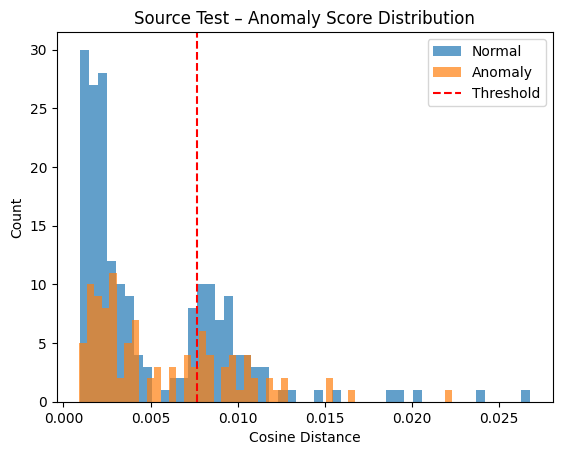

In [26]:
import matplotlib.pyplot as plt

plt.hist(source_normal, bins=50, alpha=0.7, label="Normal")
plt.hist(source_anomaly, bins=50, alpha=0.7, label="Anomaly")
plt.axvline(best_threshold, color='r', linestyle='--', label="Threshold")
plt.legend()
plt.title("Source Test – Anomaly Score Distribution")
plt.xlabel("Cosine Distance")
plt.ylabel("Count")
plt.show()


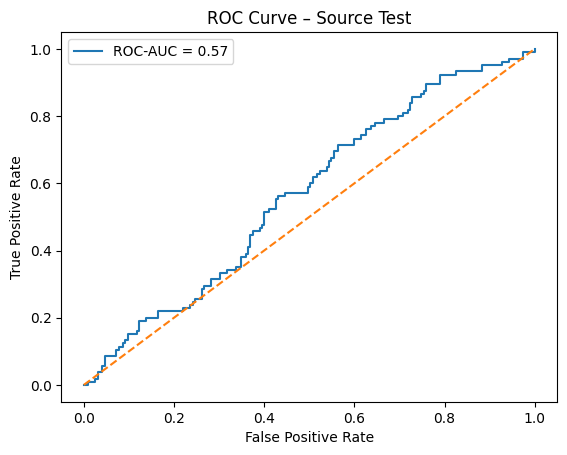

In [27]:
from sklearn.metrics import roc_curve, auc

y_true = [0 if "normal" in f.lower() else 1 for f in source_files]
fpr, tpr, _ = roc_curve(y_true, source_scores)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"ROC-AUC = {roc_auc:.2f}")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.title("ROC Curve – Source Test")
plt.show()


testing


In [28]:
import cv2
import numpy as np

IMG_SIZE = 224

def load_single_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img.astype("float32") / 255.0
    img = np.expand_dims(img, axis=-1)   # (224,224,1)
    img = np.expand_dims(img, axis=0)    # (1,224,224,1)
    return img


In [29]:
def extract_normalized_feature(image_path, encoder):
    img = load_single_image(image_path)
    feat = encoder.predict(img, verbose=0)
    feat = feat.reshape(-1)

    # L2 normalize
    feat = feat / (np.linalg.norm(feat) + 1e-10)
    return feat


In [30]:
def cosine_distance(feature, centroid):
    return 1 - np.dot(feature, centroid)


In [31]:
def classify_image(image_path, encoder, centroid, threshold):
    feature = extract_normalized_feature(image_path, encoder)
    score = cosine_distance(feature, centroid)

    if score > threshold:
        label = "ANOMALY"
    else:
        label = "NORMAL"

    return label, score


In [77]:
# your chosen threshold (70th percentile)
best_threshold = np.percentile(source_normal, 62.5)
print(best_threshold)
# example image
test_image_path =  r"C:\Users\praka\OneDrive\Desktop\Machine Learning\Deep-Learning\ImageToSpectrogramPrediction\SpectrogramImage\target_test\section_00_target_test_anomaly_0004.png"
label, score = classify_image(
    test_image_path,
    encoder,
    centroid,
    best_threshold
)

print("Prediction:", label)
print("Anomaly Score:", score)


0.0048237443
Prediction: NORMAL
Anomaly Score: 0.0016267896


In [78]:
scores = source_scores  # or target_scores or combined_scores

scores = np.array(scores)
print("Total samples:", len(scores))

Total samples: 300


In [79]:
from sklearn.cluster import KMeans
import numpy as np

# reshape to (n_samples, 1)
scores_reshaped = scores.reshape(-1, 1)

kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(scores_reshaped)

# cluster labels for each sample
cluster_labels = kmeans.labels_


In [80]:
# compute mean score per cluster
cluster_means = [(i, scores[cluster_labels == i].mean()) for i in range(3)]
cluster_means_sorted = sorted(cluster_means, key=lambda x: x[1])

print("Cluster severity order:", cluster_means_sorted)


Cluster severity order: [(0, np.float32(0.0024186508)), (1, np.float32(0.008973925)), (2, np.float32(0.018973665))]


In [81]:
# map clusters to labels
level_map = {
    cluster_means_sorted[0][0]: "NORMAL",
    cluster_means_sorted[1][0]: "NEEDS MAINTENANCE",
    cluster_means_sorted[2][0]: "ANOMALY"
}

print(level_map)


{0: 'NORMAL', 1: 'NEEDS MAINTENANCE', 2: 'ANOMALY'}


In [82]:
def classify_3level(score, kmeans, level_map):
    cluster = kmeans.predict(np.array(score).reshape(-1, 1))[0]
    return level_map[cluster]


In [86]:
import numpy as np
import os

def extract_features_from_folder(folder_path, encoder):
    features = []

    for file in os.listdir(folder_path):
        if file.endswith(".png") or file.endswith(".jpg"):
            img_path = os.path.join(folder_path, file)
            img = load_single_image(img_path)      # your preprocessing function
            feat = encoder.predict(img, verbose=0)
            feat = feat.reshape(-1)               # flatten
            features.append(feat)

    features = np.array(features)
    return features

# ---- RUN THIS ON NORMAL TRAIN IMAGES ----
train_normal_features = extract_features_from_folder(r"C:\Users\praka\OneDrive\Desktop\Machine Learning\Deep-Learning\ImageToSpectrogramPrediction\SpectrogramImage\train", encoder)


In [87]:
from sklearn.decomposition import PCA

pca_dim = 128   # you can try 64, 128, or 256

pca = PCA(n_components=pca_dim)
train_normal_pca = pca.fit_transform(train_normal_features)

print(train_normal_pca.shape)  # (num_samples, 128)


(1004, 128)


In [88]:
import numpy as np

mean_vec = np.mean(train_normal_pca, axis=0)
cov_matrix = np.cov(train_normal_pca, rowvar=False)

# numerical stability
cov_matrix += np.eye(cov_matrix.shape[0]) * 1e-6

inv_cov = np.linalg.inv(cov_matrix)


In [94]:
def mahalanobis_distance(x, mean_vec, inv_cov):
    x = x.astype(np.float64)
    delta = x - mean_vec
    dist = np.sqrt(delta @ inv_cov @ delta.T)
    return float(dist)  # convert numpy float to python float


In [95]:
def score_image_mahalanobis(image_path, encoder, pca, mean_vec, inv_cov):
    img = load_single_image(image_path)
    
    # predict feature
    feat = encoder.predict(img, verbose=0).reshape(-1)
    
    # convert to float64 before PCA transform
    feat = feat.astype(np.float64)

    # PCA reduction (output becomes float64 automatically)
    feat_pca = pca.transform([feat])[0]

    return mahalanobis_distance(feat_pca, mean_vec, inv_cov)


In [100]:
kmeans.cluster_centers_ = kmeans.cluster_centers_.astype(np.float64)

def classify_3level(score, kmeans, level_map):
    score_arr = np.array([[score]], dtype=np.float64)   # <-- force float64 & 2D
    cluster = kmeans.predict(score_arr)[0]
    return level_map[cluster]


In [111]:
test_image_path = r"C:\Users\praka\OneDrive\Desktop\Machine Learning\Deep-Learning\ImageToSpectrogramPrediction\SpectrogramImage\target_test\section_00_target_test_normal_0001.png"

score = score_image_mahalanobis(test_image_path, encoder, pca, mean_vec, inv_cov)
label = classify_3level(score, kmeans, level_map)

print("Anomaly score:", score)
print("Condition:", label)


Anomaly score: 17.831623240638358
Condition: ANOMALY


In [ ]:
# import os
# import glob

# scores = []

# test_image_dir = r"C:\Users\praka\OneDrive\Desktop\Machine Learning\Deep-Learning\ImageToSpectrogramPrediction\SpectrogramImage\train"

# image_paths = glob.glob(os.path.join(test_image_dir, "*.png"))

# for path in image_paths:
#     s = score_image_mahalanobis(path, encoder, pca, mean_vec, inv_cov)
#     scores.append(s)

# print("Min:", min(scores))
# print("Max:", max(scores))
# print("First 20 scores:", scores[:20])


Min: 3.7064188714800395
Max: 26.445849291435753
First 20 scores: [12.689785250618735, 17.96808085263289, 6.35954096090349, 11.356632627059442, 9.73432962759355, 26.445849291435753, 16.82804333405082, 5.417573062888104, 9.50305696219541, 21.61726634521754, 5.836030269788756, 15.649950861900173, 10.073160819399051, 5.536438546313705, 9.83134063291552, 5.890856953220207, 11.54424863700559, 11.179713849798478, 11.538467922249769, 6.099395447678677]


In [119]:
def classify_3levels_by_threshold(score):
    if score < 9:
        return "NORMAL"
    elif score < 15:
        return "MEDIUM ANOMALY"
    else:
        return "SEVERE ANOMALY"


In [137]:
test_image_path = r"C:\Users\praka\OneDrive\Desktop\Machine Learning\Deep-Learning\ImageToSpectrogramPrediction\SpectrogramImage\target_test\section_00_target_test_anomaly_0047.png"

score = score_image_mahalanobis(test_image_path, encoder, pca, mean_vec, inv_cov)
label = classify_3levels_by_threshold(score)

print("Anomaly score:", score)
print("Condition:", label)


Anomaly score: 12.430004742600044
Condition: MEDIUM ANOMALY


In [138]:
import glob, os
test_image_dir = r"C:\Users\praka\OneDrive\Desktop\Machine Learning\Deep-Learning\ImageToSpectrogramPrediction\SpectrogramImage\train"
image_paths = glob.glob(os.path.join(test_image_dir, "*.png"))
print(len(image_paths))
print(image_paths[:5])


1004
['C:\\Users\\praka\\OneDrive\\Desktop\\Machine Learning\\Deep-Learning\\ImageToSpectrogramPrediction\\SpectrogramImage\\train\\section_00_source_train_normal_0000_0_g_25_mm_2000_mV_none.png', 'C:\\Users\\praka\\OneDrive\\Desktop\\Machine Learning\\Deep-Learning\\ImageToSpectrogramPrediction\\SpectrogramImage\\train\\section_00_source_train_normal_0001_0_g_25_mm_2000_mV_none.png', 'C:\\Users\\praka\\OneDrive\\Desktop\\Machine Learning\\Deep-Learning\\ImageToSpectrogramPrediction\\SpectrogramImage\\train\\section_00_source_train_normal_0002_0_g_25_mm_1000_mV_none.png', 'C:\\Users\\praka\\OneDrive\\Desktop\\Machine Learning\\Deep-Learning\\ImageToSpectrogramPrediction\\SpectrogramImage\\train\\section_00_source_train_normal_0003_100_g_25_mm_2000_mV_none.png', 'C:\\Users\\praka\\OneDrive\\Desktop\\Machine Learning\\Deep-Learning\\ImageToSpectrogramPrediction\\SpectrogramImage\\train\\section_00_source_train_normal_0004_250_g_25_mm_2000_mV_none.png']


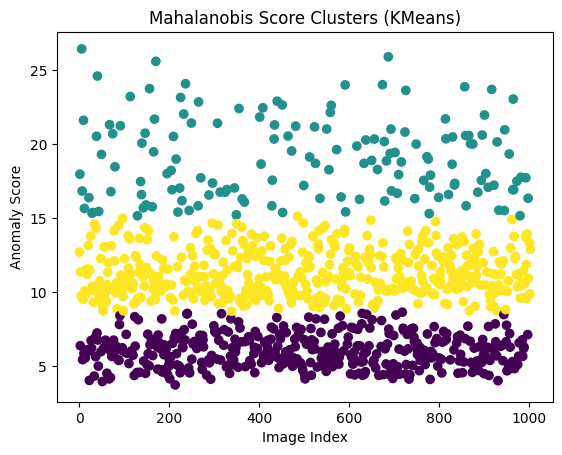

Cluster centers: [ 6.02767555 19.00911799 11.27764255]


In [139]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

scores = []
for path in image_paths:
    s = score_image_mahalanobis(path, encoder, pca, mean_vec, inv_cov)
    scores.append(s)

scores_arr = np.array(scores).reshape(-1, 1)

kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(scores_arr)

plt.figure()
plt.scatter(range(len(scores)), scores, c=clusters)  # default colors ok
plt.title("Mahalanobis Score Clusters (KMeans)")
plt.xlabel("Image Index")
plt.ylabel("Anomaly Score")
plt.show()

print("Cluster centers:", kmeans.cluster_centers_.flatten())
